In [291]:
import tensorflow as tf
import deepxde as dde # import statements
import numpy as np

Geometry class
---

Appears to define the domain of the dimensions

dde.geometry.___

.TimeDomain(t0, t1)
Create the region of time in which your program will exist
t0, t1 being the beginning and end of that time




In [292]:
# geom = dde.geometry.TimeDomain(0, 10) # set time to range from 0 to 10

# geom = dde.geometry.Rectangle([0, -1], [10, 1]) # set physical domain in 2D

geom = dde.geometry.Interval(np.pi / 2, 3* np.pi / 2) # domain in 1D

Gradients
---

dde.grad.___

.jacobian(y, x, i=None, j=None)
returns a first order derivative. y is the output tensor, x is the input tensor, i is the row of the desired gradient, j is the column of the desired gradient. If i is not defined, it outputs the entire j'th column, and vice versa. i and j can only both be None if there is only one output in the calculated tensor, in which case it will be returned.

.hessian(y, x, component=0, i=0, j=0)
returns a second order derivative. Honestly I can't figure out what component is, remaining variables are the same as .jacobian

In [293]:
def diff_EQ(x, u): # simple differential equation to test on
    u_xx = dde.grad.hessian(u, x) # take second derivative
    return [u + u_xx] # return as a list, sin + -sin should equal 0


Initial and Boundary Conditions
---

Initial conditions - time-dependent

dde.utils.isclose(a, b)
a, b: array-like inputs to compare
Compares a and b element by element. a[i] and b[i] don't have to be a perfect match to be considered the same. The accuracy of the number (Double, float, quad, etc) will determine how 'tolerant' the function is of mistakes. Higher accuracy = less tolerance.
returns an array of bools signifying if the elements at that index were similar enough.

dde.icbb.IC(geom, func, on_initial, component=0)
geom: domain in which the initial conditions occur
func: a function telling us what the outputs for the intial conditions are
on_initial: a function telling us if the input is in the range of the initial conditions
component: tells us which group of initial conditions we are in


Boundary conditions

dde.icbc.DirichletBC(geom, func, on_boundary, component)
same as initial boundary class



In [294]:
pi2 = np.pi / 2
pi32 = float((3 * np.pi) / 2)



def is_boundary0(x, on_boundary): # tells us if x is 0, must have 2 args
    return dde.utils.isclose(x[0], 0) and on_boundary

def is_boundary1(x, on_boundary): # tells us if y is 1
    return dde.utils.isclose(x[0], pi2) and on_boundary

def is_boundary2(x, on_boundary):
    return dde.utils.isclose(x[0], pi32) and on_boundary

# def is_boundary3(x, on_boundary):
#     return dde.utils.isclose(x[0], np.pi)

bc0 = dde.icbc.DirichletBC(geom, lambda u: 0, is_boundary0)
# bc1 = dde.icbc.DirichletBC(geom, lambda u: 0, is_boundary3)
bc2 = dde.icbc.DirichletBC(geom, lambda u: 1, is_boundary1)
bc3 = dde.icbc.DirichletBC(geom, lambda u: -1, is_boundary2)





BCs = [bc2, bc3]


PDE 
---

data.PDE(geometry, pde, bcs, numdomain(int), num_boundary(int), train_distribution(string), anchors, exclusions, solution, num_test, auxiliary_var_function)

Creates a ODE of time-independent PDE solver.
geometry: an instance of Geometry class
pde: one or a list of PDEs, appears to act as the residual function
bcs: One or a list of boundary conditions, use [] if there are none.
num_domain: Number of training points to be sampled within the domain
num_boundary: The number of training points to be sampled on the boundary
train_distribution: Distribution of to sample training points. "uniform", "pseudo" (pseudorandom), "LHS", "Halton", "Hammersley", "Sobol"
anchors: Numpy array of training points to be sampled, in addition to num_domain and num_boundary
exlusions: Numpy array of points not to be trained on
solution: reference solution
num_test: number of points to be sampled within the domain to assess PDE loss. If None, then training points will be used for testing.
auxiliary_var_function: A function that inputs 'train_x' or 'test_x' and outputs auxiliary variables


In [295]:
num_train_sample = 750
num_bound_sample = 750

def sol_function(x): # the actual function it is to approximate accuracy
    return np.sin(x)

all_data = dde.data.PDE(geom, diff_EQ, BCs, num_train_sample, num_bound_sample, solution=sol_function, num_test=50)


Network Structure
---

denoting layers:
layer_size = [1] + [20] * 3 + [1]
Reads as: 1 output node, 3 sets (layers) of 20 nodes, 1 input node
activation = "tanh", "elu", "gelu", "relu", "selu", "sigmoid", "silu", "sin" or "swish"
initializer = "Glorot normal / uniform", "He normal / uniform", "LeCun normal / uniform", "Orthogonal" or "zeros"

FNN (Fully-connected Neural Network)
network = dde.nn.FNN(layer_size, activation, initializer, regularization=None, dropout_rate=0, batch_normalization=None, layer_normalization=None, kernel_constraint=None, use_bias=True)

batch_normalization: string denoting if batch normalization is to occur "before" or "after" the activation function
layer_normalization: string denoting if batch normalization is to occur "before" or "after" the activation function

batch_normalization and layer_normalization cannot be the same

Can't figure out other variables, perhaps leave them be

In [296]:
layer_size = [1] + [16] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
network = dde.nn.FNN(layer_size, activation, initializer, dropout_rate=.5)


Training the network
---


Creating the Model - 
dde.Model(data, net)

data: the PDE / ODE, along with all it's information about domain, initial conditions, etc
net: network structure to execute on


Compiling - 
model.compile(optimizer, lr=None, loss="MSE", metrics=None, decay=None, loss_weights=None, external_trainable_variables=None)

metrics: list of strings. "accuracy", "12 relative error", "nan12 relative error", "mean 12 relative error", "mean sqared error / MSE / mse", "MAPE" (mean absolute percentage error), "max APE" (max absolute percentage error), "APE SD" (absolute percentage error std)
decay: decay of initial learning rate. ("inverse time", decay_steps, decay_rate) or ("cosine", decay_steps, alpha)
loss_weights: a list of scalars to weigh loss contributions
external_trainable_variables: One or a list of dde.Variable objects. Is ignored and automatically collected if using tensorflow.v1


Training -
losshistory, train_state = model.train(iterations=epochs, batch_size= None, display_every=1000)

Will display:
Step      Train Loss      Test Loss      

Test Metric 


Saving -
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

save and plot the best trained result and loss history



Compiling model...
Building feed-forward neural network...
'build' took 0.086925 s



C:\Users\werea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\werea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:99: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  y = tf.layers.dropout(y, rate=self.dropout_rate, training=self.training)


'compile' took 1.312886 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.24e-01, 1.36e+00, 1.78e+00]    [4.84e-02, 6.84e-01, 1.61e+00]    [1.10e+00]    
1000      [2.27e-01, 1.16e-01, 1.82e-01]    [8.84e-02, 3.16e-02, 3.42e-02]    [3.66e-02]    
2000      [2.40e-01, 8.78e-02, 1.67e-01]    [7.94e-02, 2.99e-02, 4.88e-02]    [4.24e-02]    
3000      [2.35e-01, 9.80e-02, 1.82e-01]    [7.71e-02, 2.83e-02, 4.37e-02]    [3.89e-02]    
4000      [2.27e-01, 8.74e-02, 1.76e-01]    [7.04e-02, 2.60e-02, 5.32e-02]    [4.18e-02]    
5000      [2.22e-01, 8.81e-02, 1.50e-01]    [6.72e-02, 2.91e-02, 4.70e-02]    [4.01e-02]    
6000      [2.27e-01, 1.01e-01, 1.49e-01]    [6.82e-02, 2.71e-02, 4.28e-02]    [3.73e-02]    
7000      [2.17e-01, 1.05e-01, 1.69e-01]    [6.68e-02, 3.11e-02, 4.51e-02]    [4.04e-02]    
8000      [2.33e-01, 9.97e-02, 1.45e-01]    [7.20e-02, 2.74e-02, 4.02e-02]    [3.69e-02]    
9000      [2.19e-01, 9.8

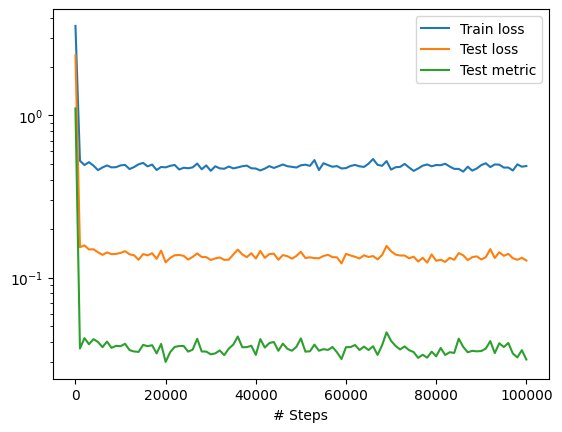

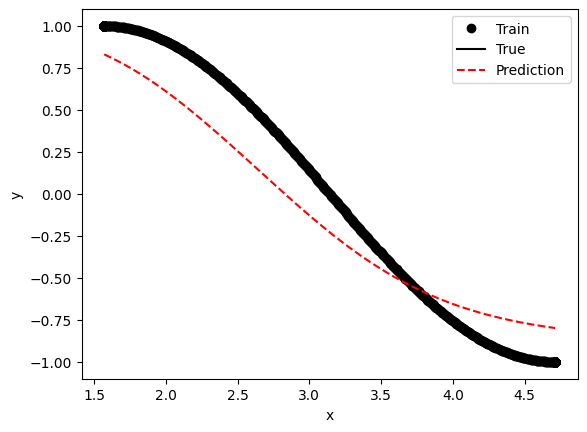

In [297]:
model = dde.Model(all_data, network)

model.compile("adam", lr=.001, metrics=["mse"])


losshistory, train_state = model.train(iterations=100000, display_every=1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)